# Assignment 3 for Data-690
by John Thomas Shaw Valanidas

Chp4 Qs: 1, 2, 3 & Chp5 Qs: 4, 5

Imports mirrored from the chapter 4 to reduce need to grab more

In [2]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision 
from torchvision import transforms

from torch.utils.data import Dataset, DataLoader

from tqdm.autonotebook import tqdm

import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.pyplot import imshow

import pandas as pd

from sklearn.metrics import accuracy_score

import time

import unicodedata
import string

import requests, zipfile, io

# NOTE: Instead of having an external file with the idlmanm imports I will include all that appear in the next cell.
# from idlmam import train_simple_network, Flatten, weight_reset

idlmam imports that are necessary for code to run without referencing a seperate file

In [3]:
def run_epoch(model, optimizer, data_loader, loss_func, device, results, score_funcs, prefix="", desc=None):
    """
    model -- the PyTorch model / "Module" to run for one epoch
    optimizer -- the object that will update the weights of the network
    data_loader -- DataLoader object that returns tuples of (input, label) pairs. 
    loss_func -- the loss function that takes in two arguments, the model outputs and the labels, and returns a score
    device -- the compute lodation to perform training
    score_funcs -- a dictionary of scoring functions to use to evalue the performance of the model
    prefix -- a string to pre-fix to any scores placed into the _results_ dictionary. 
    desc -- a description to use for the progress bar.     
    """
    running_loss = []
    y_true = []
    y_pred = []
    start = time.time()
    for inputs, labels in tqdm(data_loader, desc=desc, leave=False):
        #Move the batch to the device we are using. 
        inputs = moveTo(inputs, device)
        labels = moveTo(labels, device)

        y_hat = model(inputs) #this just computed f_Θ(x(i))
        # Compute loss.
        loss = loss_func(y_hat, labels)

        if model.training:
            loss.backward()
            optimizer.step()
            optimizer.zero_grad()

        #Now we are just grabbing some information we would like to have
        running_loss.append(loss.item())

        if len(score_funcs) > 0 and isinstance(labels, torch.Tensor):
            #moving labels & predictions back to CPU for computing / storing predictions
            labels = labels.detach().cpu().numpy()
            y_hat = y_hat.detach().cpu().numpy()
            #add to predictions so far
            y_true.extend(labels.tolist())
            y_pred.extend(y_hat.tolist())
    #end training epoch
    end = time.time()
    
    y_pred = np.asarray(y_pred)
    if len(y_pred.shape) == 2 and y_pred.shape[1] > 1: #We have a classification problem, convert to labels
        y_pred = np.argmax(y_pred, axis=1)
    #Else, we assume we are working on a regression problem
    
    results[prefix + " loss"].append( np.mean(running_loss) )
    for name, score_func in score_funcs.items():
        try:
            results[prefix + " " + name].append( score_func(y_true, y_pred) )
        except:
            results[prefix + " " + name].append(float("NaN"))
    return end-start #time spent on epoch

def train_simple_network(model, loss_func, train_loader, test_loader=None, score_funcs=None, 
                         epochs=50, device="cpu", checkpoint_file=None, lr=0.001):
    """Train simple neural networks
    
    Keyword arguments:
    model -- the PyTorch model / "Module" to train
    loss_func -- the loss function that takes in batch in two arguments, the model outputs and the labels, and returns a score
    train_loader -- PyTorch DataLoader object that returns tuples of (input, label) pairs. 
    test_loader -- Optional PyTorch DataLoader to evaluate on after every epoch
    score_funcs -- A dictionary of scoring functions to use to evalue the performance of the model
    epochs -- the number of training epochs to perform
    device -- the compute lodation to perform training
    
    """
    to_track = ["epoch", "total time", "train loss"]
    if test_loader is not None:
        to_track.append("test loss")
    for eval_score in score_funcs:
        to_track.append("train " + eval_score )
        if test_loader is not None:
            to_track.append("test " + eval_score )
        
    total_train_time = 0 #How long have we spent in the training loop? 
    results = {}
    #Initialize every item with an empty list
    for item in to_track:
        results[item] = []
        
    #SGD is Stochastic Gradient Decent.
    optimizer = torch.optim.SGD(model.parameters(), lr=0.001)
    #Place the model on the correct compute resource (CPU or GPU)
    model.to(device)
    for epoch in tqdm(range(epochs), desc="Epoch"):
        model = model.train()#Put our model in training mode
        
        total_train_time += run_epoch(model, optimizer, train_loader, loss_func, device, results, score_funcs, prefix="train", desc="Training")

        results["total time"].append( total_train_time )
        results["epoch"].append( epoch )
        
        if test_loader is not None:
            model = model.eval()
            with torch.no_grad():
                run_epoch(model, optimizer, test_loader, loss_func, device, results, score_funcs, prefix="test", desc="Testing")
                    
    if checkpoint_file is not None:
        torch.save({
            'epoch': epoch,
            'model_state_dict': model.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            'results' : results
            }, checkpoint_file)

    return pd.DataFrame.from_dict(results)

def set_seed(seed):
    torch.manual_seed(seed)
    np.random.seed(seed)

class Flatten(nn.Module):
    def forward(self, input):
        return input.view(input.size(0), -1)
    
def weight_reset(m):
    """
    Go through a PyTorch module m and reset all the weights to an initial random state
    """
    if "reset_parameters" in dir(m):
        m.reset_parameters()
    return

def moveTo(obj, device):
    """
    obj: the python object to move to a device, or to move its contents to a device
    device: the compute device to move objects to
    """
    if hasattr(obj, "to"):
        return obj.to(device)
    elif isinstance(obj, list):
        return [moveTo(x, device) for x in obj]
    elif isinstance(obj, tuple):
        return tuple(moveTo(list(obj), device))
    elif isinstance(obj, set):
        return set(moveTo(list(obj), device))
    elif isinstance(obj, dict):
        to_ret = dict()
        for key, value in obj.items():
            to_ret[moveTo(key, device)] = moveTo(value, device)
        return to_ret
    else:
        return 

Device setting code to take advantage of GPU if it exists

In [4]:
device = torch.device("cpu")

if(torch.cuda.is_available()):
    device = torch.device("cuda")

print(f"Torch Device: {device}")

Torch Device: cuda


Set seed information

In [5]:
torch.manual_seed(1)

# Chapter 4 Question 1

Modify `LanguageNameDataset` so the `vocabulary` object in the constructor does not need to be passed in as an argument but instead can be inferred from the input dataset. This means you need to iterate through the dataset and create a dictionary with all the characters actually seen. One way to implement this is to create a default value `vocabulary=None` and use `is vocabulary None:` to change behavior.

In [6]:
zip_file_url = "https://download.pytorch.org/tutorial/data.zip"

r = requests.get(zip_file_url)
z = zipfile.ZipFile(io.BytesIO(r.content))
z.extractall()

#Zip file is organized as data/names/[LANG].txt , where [LANG] is a specific language

In [7]:
namge_language_data = {}

#We will use some code to remove UNICODE tokens to make life easy for us processing wise
#e.g., convert something like "Ślusàrski" to Slusarski

all_letters = string.ascii_letters + " .,;'"
n_letters = len(all_letters)
alphabet = {}
for i in range(n_letters):
    alphabet[all_letters[i]] = i
    
# Turn a Unicode string to plain ASCII, thanks to https://stackoverflow.com/a/518232/2809427
def unicodeToAscii(s):
    return ''.join(
        c for c in unicodedata.normalize('NFD', s)
        if unicodedata.category(c) != 'Mn'
        and c in all_letters
    )

#Loop through every language, open the zip file entry, and read all the lines from the text file. 
for zip_path in z.namelist():
    if "data/names/" in zip_path and zip_path.endswith(".txt"):
        lang = zip_path[len("data/names/"):-len(".txt")]
        with z.open(zip_path) as myfile:
            # NOTE: Removed the unicode to ascii call here...
            lang_names = [line.lower() for line in str(myfile.read(), encoding='utf-8').strip().split("\n")]
            namge_language_data[lang] = lang_names
        print(lang, ": ", len(lang_names)) #Print out the name of each language too. 

Arabic :  2000
Chinese :  268
Czech :  519
Dutch :  297
English :  3668
French :  277
German :  724
Greek :  203
Irish :  232
Italian :  709
Japanese :  991
Korean :  94
Polish :  139
Portuguese :  74
Russian :  9408
Scottish :  100
Spanish :  298
Vietnamese :  73


In [8]:
def createVocabularyFromInput(dataset):
    """
    constructs a vocabulary based on the input's dataset.
    """
    vocabulary = {}
    character_id = 0
    for language, sample in dataset.items():
        for data_point in sample:
            for character in data_point:
                if character not in vocabulary:
                    vocabulary[character] = character_id
                    character_id += 1
    return vocabulary


class LanguageNameDataset(Dataset):
    
    def __init__(self, lang_name_dict, vocabulary=None):
        self.label_names = [x for x in lang_name_dict.keys()]
        self.data = []
        self.labels = []
        
        # init vocabulary
        if (vocabulary):
            self.vocabulary = vocabulary
        else:
            self.vocabulary = createVocabularyFromInput(lang_name_dict)
        
        # init dataset
        for y, language in enumerate(self.label_names):
            for sample in lang_name_dict[language]:
                self.data.append(sample)
                self.labels.append(y)
        
    def __len__(self):
        return len(self.data)
    
    def string2InputVec(self, input_string):
        """
        This method will convert any input string into a vector of long values, according to the vocabulary used by this object. 
        input_string: the string to convert to a tensor
        """
        T = len(input_string) #How many characters long is the string?
        
        #Create a new tensor to store the result in
        name_vec = torch.zeros((T), dtype=torch.long)
        #iterate through the string and place the appropriate values into the tensor
        for pos, character in enumerate(input_string):
            name_vec[pos] = self.vocabulary[character]
            
        return name_vec
    
    def __getitem__(self, idx):
        name = self.data[idx]
        label = self.labels[idx]
        
        #Conver the correct class label into a tensor for PyTorch
        label_vec = torch.tensor([label], dtype=torch.long)
        
        return self.string2InputVec(name), label

In [9]:
dataset = LanguageNameDataset(namge_language_data)

dataset[3]

(tensor([11, 10,  4, 11, 10,  8]), 0)

### Remarks:

Now that we have this adjusted, we could removed the inital normalizing of the langauge data to ASCII since unicode is now supported. I can see two things happening. First, there might be better accuracy when training on certian languages that utilize greater amounts of special characters, and even more improtantly you don't have to normalize an input. Secondly there might be some unintended consequences based on the data. If, for example, the name `John-Thomas` has several unicode characters instead of a standard ASCII representation it could skew away from the ideal result as the tokenization will have the unicode characters become very different vocabulary values. 

__Note to self: Bring this up on Monday and ask about normalization schemes with reference to this question.__


...Didn't even look at the next question and it __literally__ addresses this...

# Chapter 4 Question 2

Update `LanguageNameDataset` with a flag in the constructor for `unicode=False`. Change any of the code you need to so that when `unicode=True`, `Language-NameDataset` instead keeps all the Unicode characters seen when `vocabulary=None` (this depends on exercise 1). Train a new RNN classifier with `unicode=True`. How does it impact the results? 

In [10]:
def createVocabularyFromInput(dataset, unicode: bool):
    """
    constructs a vocabulary based on the input's dataset.
    """
    vocabulary = {}
    character_id = 0
    for language, sample in dataset.items():
        for data_point in sample:
            if (not unicode):
                # unicodeToAscii already defined in the chapter 4 notebook. see a few cells above for def  
                data_point = unicodeToAscii(data_point)
            
            for character in data_point:
                if character not in vocabulary:
                    vocabulary[character] = character_id
                    character_id += 1
    return vocabulary

class LanguageNameDataset(Dataset):
    
    def __init__(self, lang_name_dict, vocabulary=None, unicode=False):
        self.label_names = [x for x in lang_name_dict.keys()]
        self.data = []
        self.labels = []
        
        # init vocabulary
        if (vocabulary):
            self.vocabulary = vocabulary
        else:
            self.vocabulary = createVocabularyFromInput(lang_name_dict, unicode)
        
        # init dataset
        for y, language in enumerate(self.label_names):
            for sample in lang_name_dict[language]:
                self.data.append(sample)
                self.labels.append(y)
        
    def __len__(self):
        return len(self.data)
    
    def string2InputVec(self, input_string):
        """
        This method will convert any input string into a vector of long values, according to the vocabulary used by this object. 
        input_string: the string to convert to a tensor
        """
        T = len(input_string) #How many characters long is the string?
        
        #Create a new tensor to store the result in
        name_vec = torch.zeros((T), dtype=torch.long)
        #iterate through the string and place the appropriate values into the tensor
        for pos, character in enumerate(input_string):
            name_vec[pos] = self.vocabulary[character]
            
        return name_vec
    
    def __getitem__(self, idx):
        name = self.data[idx]
        label = self.labels[idx]
        
        #Conver the correct class label into a tensor for PyTorch
        label_vec = torch.tensor([label], dtype=torch.long)
        
        return self.string2InputVec(name), label

Create two language datasets one ascii another unicode

In [11]:

ascii_language_data = {}
unicode_languge_data = {}

#We will use some code to remove UNICODE tokens to make life easy for us processing wise
#e.g., convert something like "Ślusàrski" to Slusarski

all_letters = string.ascii_letters + " .,;'"
n_letters = len(all_letters)
alphabet = {}
for i in range(n_letters):
    alphabet[all_letters[i]] = i
    
# Turn a Unicode string to plain ASCII, thanks to https://stackoverflow.com/a/518232/2809427
def unicodeToAscii(s):
    return ''.join(
        c for c in unicodedata.normalize('NFD', s)
        if unicodedata.category(c) != 'Mn'
        and c in all_letters
    )

#Loop through every language, open the zip file entry, and read all the lines from the text file. 
for zip_path in z.namelist():
    if "data/names/" in zip_path and zip_path.endswith(".txt"):
        lang = zip_path[len("data/names/"):-len(".txt")]
        with z.open(zip_path) as myfile:
            # destructured the array comp line a bit to allow for readability 
            # even if it's a bit too far to the right
            ascii_lang_names = []
            unicode_lang_names = []
            for line in str(myfile.read(), encoding='utf-8').strip().split("\n"):
                ascii_lang_names.append(unicodeToAscii(line.lower()))
                unicode_lang_names.append(line.lower())            
#             unicode_lang_names = [line.lower() for line in str(myfile.read(), encoding='utf-8').strip().split("\n")]
#             ascii_lang_names = [unicodeToAscii(line.lower()) for line in str(myfile.read(), encoding='utf-8').strip().split("\n")]
            ascii_language_data[lang] = ascii_lang_names
            unicode_languge_data[lang] = unicode_lang_names
#         print(lang, ": ", len(ascii_lang_names)) #Print out the name of each language too. 

Pull other code out of textbook for creating NN modules as well as batch loading.

In [12]:
def pad_and_pack(batch):
    #1, 2, & 3: organize the batch input lengths, inputs, and outputs as seperate lists
    input_tensors = []
    labels = []
    lengths = []
    for x, y in batch:
        input_tensors.append(x)
        labels.append(y)
        lengths.append(x.shape[0]) #Assume shape is (T, *)
    #4: create the padded version of the input
    x_padded = torch.nn.utils.rnn.pad_sequence(input_tensors, batch_first=False)
    #5: create the packed version from the padded & lengths
    x_packed = torch.nn.utils.rnn.pack_padded_sequence(x_padded, lengths, batch_first=False, enforce_sorted=False)
    #Convert the lengths into a tensor
    y_batched = torch.as_tensor(labels, dtype=torch.long)
    #6: return a tuple of the packed inputs and their labels
    return x_packed, y_batched

class EmbeddingPackable(nn.Module):
    """
    The embedding layer in PyTorch does not support Packed Sequence objects. 
    This wrapper class will fix that. If a normal input comes in, it will 
    use the regular Embedding layer. Otherwise, it will work on the packed 
    sequence to return a new Packed sequence of the appropriate result. 
    """
    def __init__(self, embd_layer):
        super(EmbeddingPackable, self).__init__()
        self.embd_layer = embd_layer 
    
    def forward(self, input):
        if type(input) == torch.nn.utils.rnn.PackedSequence:
            # We need to unpack the input, 
            sequences, lengths = torch.nn.utils.rnn.pad_packed_sequence(input.cpu(), batch_first=True)
            #Embed it
            sequences = self.embd_layer(sequences.to(input.data.device))
            #And pack it into a new sequence
            return torch.nn.utils.rnn.pack_padded_sequence(sequences, lengths.cpu(), 
                                                           batch_first=True, enforce_sorted=False)
        else:#apply to normal data
            return self.embd_layer(input)

class LastTimeStep(nn.Module):
    """
    A class for extracting the hidden activations of the last time step following 
    the output of a PyTorch RNN module. 
    """
    def __init__(self, rnn_layers=1, bidirectional=False):
        super(LastTimeStep, self).__init__()
        self.rnn_layers = rnn_layers
        if bidirectional:
            self.num_driections = 2
        else:
            self.num_driections = 1    
    
    def forward(self, input):
        #Result is either a tupe (out, h_t)
        #or a tuple (out, (h_t, c_t))
        rnn_output = input[0]
        last_step = input[1] #this will be h_t
        if(type(last_step) == tuple):#unless it's a tuple, 
            last_step = last_step[0]#then h_t is the first item in the tuple
        batch_size = last_step.shape[1] #per docs, shape is: '(num_layers * num_directions, batch, hidden_size)'
        #reshaping so that everything is separate 
        last_step = last_step.view(self.rnn_layers, self.num_driections, batch_size, -1)
        #We want the last layer's results
        last_step = last_step[self.rnn_layers-1] 
        #Re order so batch comes first
        last_step = last_step.permute(1, 0, 2)
        #Finally, flatten the last two dimensions into one
        return last_step.reshape(batch_size, -1)

In [13]:
ascii_dataset = LanguageNameDataset(ascii_language_data, unicode=False)
unicode_dataset = LanguageNameDataset(unicode_languge_data, unicode=True)

batch_size = 16

ascii_train_data, ascii_test_data = torch.utils.data.random_split(ascii_dataset, (len(ascii_dataset)-300, 300))
ascii_train_loader = DataLoader(ascii_train_data, batch_size=batch_size, shuffle=True, collate_fn=pad_and_pack)
ascii_test_loader = DataLoader(ascii_test_data, batch_size=batch_size, shuffle=False, collate_fn=pad_and_pack)

unicode_train_data, unicode_test_data = torch.utils.data.random_split(unicode_dataset, (len(unicode_dataset)-300, 300))
unicode_train_loader = DataLoader(unicode_train_data, batch_size=batch_size, shuffle=True, collate_fn=pad_and_pack)
unicode_test_loader = DataLoader(unicode_test_data, batch_size=batch_size, shuffle=False, collate_fn=pad_and_pack)

In [14]:
ascii_vocabulary_size = len(ascii_dataset.vocabulary)
unicode_vocabulary_size = len(unicode_dataset.vocabulary)

D = 64
hidden_nodes = 256
classes = len(dataset.labels)

rnn_unicode = nn.Sequential(
  EmbeddingPackable(nn.Embedding(unicode_vocabulary_size, D)), #(B, T) -> (B, T, D)
  nn.RNN(D, hidden_nodes, num_layers=3, batch_first=True), #(B, T, D) -> ( (B,T,D) , (S, B, D)  )
  LastTimeStep(rnn_layers=3), #We need to take the RNN output and reduce it to one item, (B, D)
  nn.Linear(hidden_nodes, classes), #(B, D) -> (B, classes)
)

rnn_ascii = nn.Sequential(
  EmbeddingPackable(nn.Embedding(ascii_vocabulary_size, D)), #(B, T) -> (B, T, D)
  nn.RNN(D, hidden_nodes, num_layers=3, batch_first=True), #(B, T, D) -> ( (B,T,D) , (S, B, D)  )
  LastTimeStep(rnn_layers=3), #We need to take the RNN output and reduce it to one item, (B, D)
  nn.Linear(hidden_nodes, classes), #(B, D) -> (B, classes)
)

rnn_unicode.to(device)
rnn_ascii.to(device)


loss_func = nn.CrossEntropyLoss()




In [15]:
epoch_count = 20

In [14]:
ascii_results = train_simple_network(rnn_ascii, loss_func, ascii_train_loader, test_loader=ascii_test_loader, score_funcs={'Accuracy': accuracy_score}, device=device, epochs=epoch_count)
unicode_results = train_simple_network(rnn_unicode, loss_func, unicode_train_loader, test_loader=unicode_test_loader, score_funcs={'Accuracy': accuracy_score}, device=device, epochs=epoch_count)


Epoch:   0%|          | 0/20 [00:00<?, ?it/s]

Training:   0%|          | 0/1236 [00:00<?, ?it/s]

Testing:   0%|          | 0/19 [00:00<?, ?it/s]

Training:   0%|          | 0/1236 [00:00<?, ?it/s]

Testing:   0%|          | 0/19 [00:00<?, ?it/s]

Training:   0%|          | 0/1236 [00:00<?, ?it/s]

Testing:   0%|          | 0/19 [00:00<?, ?it/s]

Training:   0%|          | 0/1236 [00:00<?, ?it/s]

Testing:   0%|          | 0/19 [00:00<?, ?it/s]

Training:   0%|          | 0/1236 [00:00<?, ?it/s]

Testing:   0%|          | 0/19 [00:00<?, ?it/s]

Training:   0%|          | 0/1236 [00:00<?, ?it/s]

Testing:   0%|          | 0/19 [00:00<?, ?it/s]

Training:   0%|          | 0/1236 [00:00<?, ?it/s]

Testing:   0%|          | 0/19 [00:00<?, ?it/s]

Training:   0%|          | 0/1236 [00:00<?, ?it/s]

Testing:   0%|          | 0/19 [00:00<?, ?it/s]

Training:   0%|          | 0/1236 [00:00<?, ?it/s]

Testing:   0%|          | 0/19 [00:00<?, ?it/s]

Training:   0%|          | 0/1236 [00:00<?, ?it/s]

Testing:   0%|          | 0/19 [00:00<?, ?it/s]

Training:   0%|          | 0/1236 [00:00<?, ?it/s]

Testing:   0%|          | 0/19 [00:00<?, ?it/s]

Training:   0%|          | 0/1236 [00:00<?, ?it/s]

Testing:   0%|          | 0/19 [00:00<?, ?it/s]

Training:   0%|          | 0/1236 [00:00<?, ?it/s]

Testing:   0%|          | 0/19 [00:00<?, ?it/s]

Training:   0%|          | 0/1236 [00:00<?, ?it/s]

Testing:   0%|          | 0/19 [00:00<?, ?it/s]

Training:   0%|          | 0/1236 [00:00<?, ?it/s]

Testing:   0%|          | 0/19 [00:00<?, ?it/s]

Training:   0%|          | 0/1236 [00:00<?, ?it/s]

Testing:   0%|          | 0/19 [00:00<?, ?it/s]

Training:   0%|          | 0/1236 [00:00<?, ?it/s]

Testing:   0%|          | 0/19 [00:00<?, ?it/s]

Training:   0%|          | 0/1236 [00:00<?, ?it/s]

Testing:   0%|          | 0/19 [00:00<?, ?it/s]

Training:   0%|          | 0/1236 [00:00<?, ?it/s]

Testing:   0%|          | 0/19 [00:00<?, ?it/s]

Training:   0%|          | 0/1236 [00:00<?, ?it/s]

Testing:   0%|          | 0/19 [00:00<?, ?it/s]

Epoch:   0%|          | 0/20 [00:00<?, ?it/s]

Training:   0%|          | 0/1236 [00:00<?, ?it/s]

Testing:   0%|          | 0/19 [00:00<?, ?it/s]

Training:   0%|          | 0/1236 [00:00<?, ?it/s]

Testing:   0%|          | 0/19 [00:00<?, ?it/s]

Training:   0%|          | 0/1236 [00:00<?, ?it/s]

Testing:   0%|          | 0/19 [00:00<?, ?it/s]

Training:   0%|          | 0/1236 [00:00<?, ?it/s]

Testing:   0%|          | 0/19 [00:00<?, ?it/s]

Training:   0%|          | 0/1236 [00:00<?, ?it/s]

Testing:   0%|          | 0/19 [00:00<?, ?it/s]

Training:   0%|          | 0/1236 [00:00<?, ?it/s]

Testing:   0%|          | 0/19 [00:00<?, ?it/s]

Training:   0%|          | 0/1236 [00:00<?, ?it/s]

Testing:   0%|          | 0/19 [00:00<?, ?it/s]

Training:   0%|          | 0/1236 [00:00<?, ?it/s]

Testing:   0%|          | 0/19 [00:00<?, ?it/s]

Training:   0%|          | 0/1236 [00:00<?, ?it/s]

Testing:   0%|          | 0/19 [00:00<?, ?it/s]

Training:   0%|          | 0/1236 [00:00<?, ?it/s]

Testing:   0%|          | 0/19 [00:00<?, ?it/s]

Training:   0%|          | 0/1236 [00:00<?, ?it/s]

Testing:   0%|          | 0/19 [00:00<?, ?it/s]

Training:   0%|          | 0/1236 [00:00<?, ?it/s]

Testing:   0%|          | 0/19 [00:00<?, ?it/s]

Training:   0%|          | 0/1236 [00:00<?, ?it/s]

Testing:   0%|          | 0/19 [00:00<?, ?it/s]

Training:   0%|          | 0/1236 [00:00<?, ?it/s]

Testing:   0%|          | 0/19 [00:00<?, ?it/s]

Training:   0%|          | 0/1236 [00:00<?, ?it/s]

Testing:   0%|          | 0/19 [00:00<?, ?it/s]

Training:   0%|          | 0/1236 [00:00<?, ?it/s]

Testing:   0%|          | 0/19 [00:00<?, ?it/s]

Training:   0%|          | 0/1236 [00:00<?, ?it/s]

Testing:   0%|          | 0/19 [00:00<?, ?it/s]

Training:   0%|          | 0/1236 [00:00<?, ?it/s]

Testing:   0%|          | 0/19 [00:00<?, ?it/s]

Training:   0%|          | 0/1236 [00:00<?, ?it/s]

Testing:   0%|          | 0/19 [00:00<?, ?it/s]

Training:   0%|          | 0/1236 [00:00<?, ?it/s]

Testing:   0%|          | 0/19 [00:00<?, ?it/s]

<AxesSubplot:xlabel='epoch', ylabel='test Accuracy'>

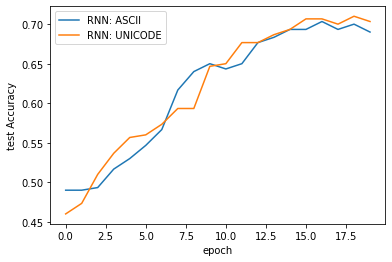

In [15]:
sns.lineplot(x='epoch', y='test Accuracy', data=ascii_results, label='RNN: ASCII')
sns.lineplot(x='epoch', y='test Accuracy', data=unicode_results, label='RNN: UNICODE')

<AxesSubplot:xlabel='total time', ylabel='test Accuracy'>

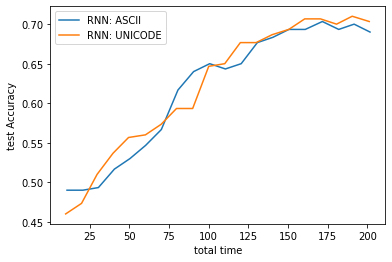

In [16]:
sns.lineplot(x='total time', y='test Accuracy', data=ascii_results, label='RNN: ASCII')
sns.lineplot(x='total time', y='test Accuracy', data=unicode_results, label='RNN: UNICODE')

### Remarks

They both appear to be performing about the same, with maybe the unicode rnn performing slightly better. In order to make a more thorough conclusion, I would have to run this experiment multiple times to ensure that it's not a fluke of the initialization weights being closer to local minimums. After collecting enough data I would try and generate a confidence rating based on the data. 

# Chapter 4 Question 3

Update `LanguageNameDataset` with a new `min_count=1` argument in the constructor. If `vocabulary=None`, it should replace any character that occurs too few times with a special "UNK" token, indicating an unknown value. How is the size of the vocabulary impacted by setting `min_count=300`, and what happens to the results?

In [16]:
UNKNOWN_CHAR = 0

def createVocabularyFromInput(dataset, unicode: bool, min_count: int):
    """
    constructs a vocabulary based on the input's dataset.
    """
    vocabulary_count = {}
    for language, sample in dataset.items():
        for data_point in sample:
            if (not unicode):
                # unicodeToAscii already defined in the chapter 4 notebook. see a few cells above for def  
                data_point = unicodeToAscii(data_point)
            
            for character in data_point:
                if character not in vocabulary_count:
                    vocabulary_count[character] = 1
                vocabulary_count[character] += 1
                
    vocabulary = {"UNK": UNKNOWN_CHAR}
    # there's probably a better programatic way this should be offset...
    character_id = 1 
    for letter in vocabulary_count:
        if vocabulary_count[letter] >= min_count:
            vocabulary[letter] = character_id
            character_id += 1
    return vocabulary

class LanguageNameDataset(Dataset):
    
    def __init__(self, lang_name_dict, vocabulary=None, unicode=False, min_count=1):
        self.label_names = [x for x in lang_name_dict.keys()]
        self.data = []
        self.labels = []
        
        # init vocabulary
        if (vocabulary):
            self.vocabulary = vocabulary
        else:
            self.vocabulary = createVocabularyFromInput(lang_name_dict, unicode, min_count)
        
        # init dataset
        for y, language in enumerate(self.label_names):
            for sample in lang_name_dict[language]:
                self.data.append(sample)
                self.labels.append(y)
        
    def __len__(self):
        return len(self.data)
    
    def string2InputVec(self, input_string):
        """
        This method will convert any input string into a vector of long values, according to the vocabulary used by this object. 
        input_string: the string to convert to a tensor
        """
        T = len(input_string) #How many characters long is the string?
        
        #Create a new tensor to store the result in
        name_vec = torch.zeros((T), dtype=torch.long)
        #iterate through the string and place the appropriate values into the tensor
        for pos, character in enumerate(input_string):
            if not self.vocabulary.get(character):
                # could allow for support of passed in vocabulary to support an unknown character entry...
                name_vec[pos] = self.vocabulary['UNK']
            else:
                name_vec[pos] = self.vocabulary[character]
            
        return name_vec
    
    def __getitem__(self, idx):
        name = self.data[idx]
        label = self.labels[idx]
        
        #Conver the correct class label into a tensor for PyTorch
        label_vec = torch.tensor([label], dtype=torch.long)
        
        return self.string2InputVec(name), label

In [17]:
min_count = 300

ascii_dataset = LanguageNameDataset(ascii_language_data, unicode=False, min_count=min_count)
unicode_dataset = LanguageNameDataset(unicode_languge_data, unicode=True, min_count=min_count)

batch_size = 16

ascii_train_data, ascii_test_data = torch.utils.data.random_split(ascii_dataset, (len(ascii_dataset)-300, 300))
ascii_train_loader = DataLoader(ascii_train_data, batch_size=batch_size, shuffle=True, collate_fn=pad_and_pack)
ascii_test_loader = DataLoader(ascii_test_data, batch_size=batch_size, shuffle=False, collate_fn=pad_and_pack)

unicode_train_data, unicode_test_data = torch.utils.data.random_split(unicode_dataset, (len(unicode_dataset)-300, 300))
unicode_train_loader = DataLoader(unicode_train_data, batch_size=batch_size, shuffle=True, collate_fn=pad_and_pack)
unicode_test_loader = DataLoader(unicode_test_data, batch_size=batch_size, shuffle=False, collate_fn=pad_and_pack)

In [18]:
ascii_vocabulary_size = len(ascii_dataset.vocabulary)
unicode_vocabulary_size = len(unicode_dataset.vocabulary)

D = 64
hidden_nodes = 256
classes = len(dataset.labels)

rnn_unicode = nn.Sequential(
  EmbeddingPackable(nn.Embedding(unicode_vocabulary_size, D)), #(B, T) -> (B, T, D)
  nn.RNN(D, hidden_nodes, num_layers=3, batch_first=True), #(B, T, D) -> ( (B,T,D) , (S, B, D)  )
  LastTimeStep(rnn_layers=3), #We need to take the RNN output and reduce it to one item, (B, D)
  nn.Linear(hidden_nodes, classes), #(B, D) -> (B, classes)
)

rnn_ascii = nn.Sequential(
  EmbeddingPackable(nn.Embedding(ascii_vocabulary_size, D)), #(B, T) -> (B, T, D)
  nn.RNN(D, hidden_nodes, num_layers=3, batch_first=True), #(B, T, D) -> ( (B,T,D) , (S, B, D)  )
  LastTimeStep(rnn_layers=3), #We need to take the RNN output and reduce it to one item, (B, D)
  nn.Linear(hidden_nodes, classes), #(B, D) -> (B, classes)
)

rnn_unicode.to(device)
rnn_ascii.to(device)


loss_func = nn.CrossEntropyLoss()

In [19]:
epoch_count = 20

In [20]:

ascii_results = train_simple_network(rnn_ascii, loss_func, ascii_train_loader, test_loader=ascii_test_loader, score_funcs={'Accuracy': accuracy_score}, device=device, epochs=epoch_count)
unicode_results = train_simple_network(rnn_unicode, loss_func, unicode_train_loader, test_loader=unicode_test_loader, score_funcs={'Accuracy': accuracy_score}, device=device, epochs=epoch_count)


Epoch:   0%|          | 0/20 [00:00<?, ?it/s]

Training:   0%|          | 0/1236 [00:00<?, ?it/s]

Testing:   0%|          | 0/19 [00:00<?, ?it/s]

Training:   0%|          | 0/1236 [00:00<?, ?it/s]

Testing:   0%|          | 0/19 [00:00<?, ?it/s]

Training:   0%|          | 0/1236 [00:00<?, ?it/s]

Testing:   0%|          | 0/19 [00:00<?, ?it/s]

Training:   0%|          | 0/1236 [00:00<?, ?it/s]

Testing:   0%|          | 0/19 [00:00<?, ?it/s]

Training:   0%|          | 0/1236 [00:00<?, ?it/s]

Testing:   0%|          | 0/19 [00:00<?, ?it/s]

Training:   0%|          | 0/1236 [00:00<?, ?it/s]

Testing:   0%|          | 0/19 [00:00<?, ?it/s]

Training:   0%|          | 0/1236 [00:00<?, ?it/s]

Testing:   0%|          | 0/19 [00:00<?, ?it/s]

Training:   0%|          | 0/1236 [00:00<?, ?it/s]

Testing:   0%|          | 0/19 [00:00<?, ?it/s]

Training:   0%|          | 0/1236 [00:00<?, ?it/s]

Testing:   0%|          | 0/19 [00:00<?, ?it/s]

Training:   0%|          | 0/1236 [00:00<?, ?it/s]

Testing:   0%|          | 0/19 [00:00<?, ?it/s]

Training:   0%|          | 0/1236 [00:00<?, ?it/s]

Testing:   0%|          | 0/19 [00:00<?, ?it/s]

Training:   0%|          | 0/1236 [00:00<?, ?it/s]

Testing:   0%|          | 0/19 [00:00<?, ?it/s]

Training:   0%|          | 0/1236 [00:00<?, ?it/s]

Testing:   0%|          | 0/19 [00:00<?, ?it/s]

Training:   0%|          | 0/1236 [00:00<?, ?it/s]

Testing:   0%|          | 0/19 [00:00<?, ?it/s]

Training:   0%|          | 0/1236 [00:00<?, ?it/s]

Testing:   0%|          | 0/19 [00:00<?, ?it/s]

Training:   0%|          | 0/1236 [00:00<?, ?it/s]

Testing:   0%|          | 0/19 [00:00<?, ?it/s]

Training:   0%|          | 0/1236 [00:00<?, ?it/s]

Testing:   0%|          | 0/19 [00:00<?, ?it/s]

Training:   0%|          | 0/1236 [00:00<?, ?it/s]

Testing:   0%|          | 0/19 [00:00<?, ?it/s]

Training:   0%|          | 0/1236 [00:00<?, ?it/s]

Testing:   0%|          | 0/19 [00:00<?, ?it/s]

Training:   0%|          | 0/1236 [00:00<?, ?it/s]

Testing:   0%|          | 0/19 [00:00<?, ?it/s]

Epoch:   0%|          | 0/20 [00:00<?, ?it/s]

Training:   0%|          | 0/1236 [00:00<?, ?it/s]

Testing:   0%|          | 0/19 [00:00<?, ?it/s]

Training:   0%|          | 0/1236 [00:00<?, ?it/s]

Testing:   0%|          | 0/19 [00:00<?, ?it/s]

Training:   0%|          | 0/1236 [00:00<?, ?it/s]

Testing:   0%|          | 0/19 [00:00<?, ?it/s]

Training:   0%|          | 0/1236 [00:00<?, ?it/s]

Testing:   0%|          | 0/19 [00:00<?, ?it/s]

Training:   0%|          | 0/1236 [00:00<?, ?it/s]

Testing:   0%|          | 0/19 [00:00<?, ?it/s]

Training:   0%|          | 0/1236 [00:00<?, ?it/s]

Testing:   0%|          | 0/19 [00:00<?, ?it/s]

Training:   0%|          | 0/1236 [00:00<?, ?it/s]

Testing:   0%|          | 0/19 [00:00<?, ?it/s]

Training:   0%|          | 0/1236 [00:00<?, ?it/s]

Testing:   0%|          | 0/19 [00:00<?, ?it/s]

Training:   0%|          | 0/1236 [00:00<?, ?it/s]

Testing:   0%|          | 0/19 [00:00<?, ?it/s]

Training:   0%|          | 0/1236 [00:00<?, ?it/s]

Testing:   0%|          | 0/19 [00:00<?, ?it/s]

Training:   0%|          | 0/1236 [00:00<?, ?it/s]

Testing:   0%|          | 0/19 [00:00<?, ?it/s]

Training:   0%|          | 0/1236 [00:00<?, ?it/s]

Testing:   0%|          | 0/19 [00:00<?, ?it/s]

Training:   0%|          | 0/1236 [00:00<?, ?it/s]

Testing:   0%|          | 0/19 [00:00<?, ?it/s]

Training:   0%|          | 0/1236 [00:00<?, ?it/s]

Testing:   0%|          | 0/19 [00:00<?, ?it/s]

Training:   0%|          | 0/1236 [00:00<?, ?it/s]

Testing:   0%|          | 0/19 [00:00<?, ?it/s]

Training:   0%|          | 0/1236 [00:00<?, ?it/s]

Testing:   0%|          | 0/19 [00:00<?, ?it/s]

Training:   0%|          | 0/1236 [00:00<?, ?it/s]

Testing:   0%|          | 0/19 [00:00<?, ?it/s]

Training:   0%|          | 0/1236 [00:00<?, ?it/s]

Testing:   0%|          | 0/19 [00:00<?, ?it/s]

Training:   0%|          | 0/1236 [00:00<?, ?it/s]

Testing:   0%|          | 0/19 [00:00<?, ?it/s]

Training:   0%|          | 0/1236 [00:00<?, ?it/s]

Testing:   0%|          | 0/19 [00:00<?, ?it/s]

<AxesSubplot:xlabel='epoch', ylabel='test Accuracy'>

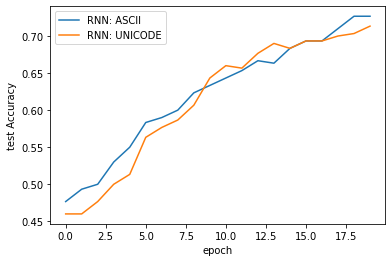

In [21]:
sns.lineplot(x='epoch', y='test Accuracy', data=ascii_results, label='RNN: ASCII')
sns.lineplot(x='epoch', y='test Accuracy', data=unicode_results, label='RNN: UNICODE')

### Remarks

First Run: It now appears that the unicode dataset is far our performing the ASCII dataset when omiting characters that don't appear often enough. I would venture out and say that because characters that don't appear often enough are being ommitted, the neural network can more quickly learn the letters that matter and thus improve faster. 

I would still want to run numerous tests to verify that this result is authentic before commiting to an awnser. 

Subsequent Runs later: Looks like they're still about the same in performance but I suspect my intuition about it being better is correct. If I were to run it over a larger span of epochs I expect the unicode performance to be better.


Currently I am fighting an issue with my gpu. I can't seem to saturate it enough and if I try to up batch sizes I get a system crash. There's probably something wrong with my drivers because I don't even hit over 10% utilization on my GPU (rtx 3080) 

# Chapter 5 Question 4
Retrain the three-layer bidirectional RNN from the last chapter with each of the new optimizers from this chapter. How do they impact the results? 


Note: I'm reusing the unicode version to see what kind of improvement we can get from that.

In [20]:
def train_network(model, loss_func, train_loader, val_loader=None, test_loader=None,score_funcs=None, 
                         epochs=50, device="cpu", checkpoint_file=None, 
                         lr_schedule=None, optimizer=None, disable_tqdm=False
                        ):
    """Train simple neural networks
    
    Keyword arguments:
    model -- the PyTorch model / "Module" to train
    loss_func -- the loss function that takes in batch in two arguments, the model outputs and the labels, and returns a score
    train_loader -- PyTorch DataLoader object that returns tuples of (input, label) pairs. 
    val_loader -- Optional PyTorch DataLoader to evaluate on after every epoch
    test_loader -- Optional PyTorch DataLoader to evaluate on after every epoch
    score_funcs -- A dictionary of scoring functions to use to evalue the performance of the model
    epochs -- the number of training epochs to perform
    device -- the compute lodation to perform training
    lr_schedule -- the learning rate schedule used to alter \eta as the model trains. If this is not None than the user must also provide the optimizer to use. 
    optimizer -- the method used to alter the gradients for learning. 
    
    """
    if score_funcs == None:
        score_funcs = {}#Empty set 
    
    to_track = ["epoch", "total time", "train loss"]
    if val_loader is not None:
        to_track.append("val loss")
    if test_loader is not None:
        to_track.append("test loss")
    for eval_score in score_funcs:
        to_track.append("train " + eval_score )
        if val_loader is not None:
            to_track.append("val " + eval_score )
        if test_loader is not None:
            to_track.append("test "+ eval_score )
        
    total_train_time = 0 #How long have we spent in the training loop? 
    results = {}
    #Initialize every item with an empty list
    for item in to_track:
        results[item] = []

        
    if optimizer == None:
        #The AdamW optimizer is a good default optimizer
        optimizer = torch.optim.AdamW(model.parameters())
        del_opt = True
    else:
        del_opt = False

    #Place the model on the correct compute resource (CPU or GPU)
    model.to(device)
    for epoch in tqdm(range(epochs), desc="Epoch", disable=disable_tqdm):
        model = model.train()#Put our model in training mode

        total_train_time += run_epoch(model, optimizer, train_loader, loss_func, device, results, score_funcs, prefix="train", desc="Training")
        
        results["epoch"].append( epoch )
        results["total time"].append( total_train_time )
        
      
        if val_loader is not None:
            model = model.eval() #Set the model to "evaluation" mode, b/c we don't want to make any updates!
            with torch.no_grad():
                run_epoch(model, optimizer, val_loader, loss_func, device, results, score_funcs, prefix="val", desc="Validating")
                
        #In PyTorch, the convention is to update the learning rate after every epoch
        if lr_schedule is not None:
            if isinstance(lr_schedule, torch.optim.lr_scheduler.ReduceLROnPlateau):
                lr_schedule.step(results["val loss"][-1])
            else:
                lr_schedule.step()
                
        if test_loader is not None:
            model = model.eval() #Set the model to "evaluation" mode, b/c we don't want to make any updates!
            with torch.no_grad():
                run_epoch(model, optimizer, test_loader, loss_func, device, results, score_funcs, prefix="test", desc="Testing")
        
        
        if checkpoint_file is not None:
            torch.save({
                'epoch': epoch,
                'model_state_dict': model.state_dict(),
                'optimizer_state_dict': optimizer.state_dict(),
                'results' : results
                }, checkpoint_file)
    if del_opt:
        del optimizer

    return pd.DataFrame.from_dict(results)

In [24]:
rnn_unicode.apply(weight_reset)

eta_0 = 0.1
eta_min = 0.0001

gamma_expo = (eta_min/eta_0)**(1/epoch_count)

optimizer = torch.optim.SGD(rnn_unicode.parameters(), lr=eta_0) #Set up the optimizer
scheduler = torch.optim.lr_scheduler.ExponentialLR(optimizer, gamma_expo)

unicode_results_exp = train_network(rnn_unicode, loss_func, unicode_train_loader, test_loader=unicode_test_loader, epochs=epoch_count, optimizer=optimizer, lr_schedule=scheduler, score_funcs={'Accuracy': accuracy_score}, device=device)

Epoch:   0%|          | 0/20 [00:00<?, ?it/s]

Training:   0%|          | 0/1236 [00:00<?, ?it/s]

Testing:   0%|          | 0/19 [00:00<?, ?it/s]

Training:   0%|          | 0/1236 [00:00<?, ?it/s]

Testing:   0%|          | 0/19 [00:00<?, ?it/s]

Training:   0%|          | 0/1236 [00:00<?, ?it/s]

Testing:   0%|          | 0/19 [00:00<?, ?it/s]

Training:   0%|          | 0/1236 [00:00<?, ?it/s]

Testing:   0%|          | 0/19 [00:00<?, ?it/s]

Training:   0%|          | 0/1236 [00:00<?, ?it/s]

Testing:   0%|          | 0/19 [00:00<?, ?it/s]

Training:   0%|          | 0/1236 [00:00<?, ?it/s]

Testing:   0%|          | 0/19 [00:00<?, ?it/s]

Training:   0%|          | 0/1236 [00:00<?, ?it/s]

Testing:   0%|          | 0/19 [00:00<?, ?it/s]

Training:   0%|          | 0/1236 [00:00<?, ?it/s]

Testing:   0%|          | 0/19 [00:00<?, ?it/s]

Training:   0%|          | 0/1236 [00:00<?, ?it/s]

Testing:   0%|          | 0/19 [00:00<?, ?it/s]

Training:   0%|          | 0/1236 [00:00<?, ?it/s]

Testing:   0%|          | 0/19 [00:00<?, ?it/s]

Training:   0%|          | 0/1236 [00:00<?, ?it/s]

Testing:   0%|          | 0/19 [00:00<?, ?it/s]

Training:   0%|          | 0/1236 [00:00<?, ?it/s]

Testing:   0%|          | 0/19 [00:00<?, ?it/s]

Training:   0%|          | 0/1236 [00:00<?, ?it/s]

Testing:   0%|          | 0/19 [00:00<?, ?it/s]

Training:   0%|          | 0/1236 [00:00<?, ?it/s]

Testing:   0%|          | 0/19 [00:00<?, ?it/s]

Training:   0%|          | 0/1236 [00:00<?, ?it/s]

Testing:   0%|          | 0/19 [00:00<?, ?it/s]

Training:   0%|          | 0/1236 [00:00<?, ?it/s]

Testing:   0%|          | 0/19 [00:00<?, ?it/s]

Training:   0%|          | 0/1236 [00:00<?, ?it/s]

Testing:   0%|          | 0/19 [00:00<?, ?it/s]

Training:   0%|          | 0/1236 [00:00<?, ?it/s]

Testing:   0%|          | 0/19 [00:00<?, ?it/s]

Training:   0%|          | 0/1236 [00:00<?, ?it/s]

Testing:   0%|          | 0/19 [00:00<?, ?it/s]

Training:   0%|          | 0/1236 [00:00<?, ?it/s]

Testing:   0%|          | 0/19 [00:00<?, ?it/s]

In [26]:
rnn_unicode.apply(weight_reset)

optimizer = torch.optim.SGD(rnn_unicode.parameters(), lr=eta_0)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, epoch_count//4, gamma=0.3)#I'm telling it to step down by a factor of $\gamma$ every epochs/4, so this will happen 4 times total. 

unicode_results_step = train_network(rnn_unicode, loss_func, unicode_train_loader, test_loader=unicode_test_loader, epochs=epoch_count, optimizer=optimizer, lr_schedule=scheduler, score_funcs={'Accuracy': accuracy_score}, device=device)

Epoch:   0%|          | 0/20 [00:00<?, ?it/s]

Training:   0%|          | 0/1236 [00:00<?, ?it/s]

Testing:   0%|          | 0/19 [00:00<?, ?it/s]

Training:   0%|          | 0/1236 [00:00<?, ?it/s]

Testing:   0%|          | 0/19 [00:00<?, ?it/s]

Training:   0%|          | 0/1236 [00:00<?, ?it/s]

Testing:   0%|          | 0/19 [00:00<?, ?it/s]

Training:   0%|          | 0/1236 [00:00<?, ?it/s]

Testing:   0%|          | 0/19 [00:00<?, ?it/s]

Training:   0%|          | 0/1236 [00:00<?, ?it/s]

Testing:   0%|          | 0/19 [00:00<?, ?it/s]

Training:   0%|          | 0/1236 [00:00<?, ?it/s]

Testing:   0%|          | 0/19 [00:00<?, ?it/s]

Training:   0%|          | 0/1236 [00:00<?, ?it/s]

Testing:   0%|          | 0/19 [00:00<?, ?it/s]

Training:   0%|          | 0/1236 [00:00<?, ?it/s]

Testing:   0%|          | 0/19 [00:00<?, ?it/s]

Training:   0%|          | 0/1236 [00:00<?, ?it/s]

Testing:   0%|          | 0/19 [00:00<?, ?it/s]

Training:   0%|          | 0/1236 [00:00<?, ?it/s]

Testing:   0%|          | 0/19 [00:00<?, ?it/s]

Training:   0%|          | 0/1236 [00:00<?, ?it/s]

Testing:   0%|          | 0/19 [00:00<?, ?it/s]

Training:   0%|          | 0/1236 [00:00<?, ?it/s]

Testing:   0%|          | 0/19 [00:00<?, ?it/s]

Training:   0%|          | 0/1236 [00:00<?, ?it/s]

Testing:   0%|          | 0/19 [00:00<?, ?it/s]

Training:   0%|          | 0/1236 [00:00<?, ?it/s]

Testing:   0%|          | 0/19 [00:00<?, ?it/s]

Training:   0%|          | 0/1236 [00:00<?, ?it/s]

Testing:   0%|          | 0/19 [00:00<?, ?it/s]

Training:   0%|          | 0/1236 [00:00<?, ?it/s]

Testing:   0%|          | 0/19 [00:00<?, ?it/s]

Training:   0%|          | 0/1236 [00:00<?, ?it/s]

Testing:   0%|          | 0/19 [00:00<?, ?it/s]

Training:   0%|          | 0/1236 [00:00<?, ?it/s]

Testing:   0%|          | 0/19 [00:00<?, ?it/s]

Training:   0%|          | 0/1236 [00:00<?, ?it/s]

Testing:   0%|          | 0/19 [00:00<?, ?it/s]

Training:   0%|          | 0/1236 [00:00<?, ?it/s]

Testing:   0%|          | 0/19 [00:00<?, ?it/s]

In [28]:
rnn_unicode.apply(weight_reset)

optimizer = torch.optim.SGD(rnn_unicode.parameters(), lr=eta_0)
scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, epoch_count//3, eta_min=0.0001)

unicode_results_cos = train_network(rnn_unicode, loss_func, unicode_train_loader, test_loader=unicode_test_loader, epochs=epoch_count, optimizer=optimizer, lr_schedule=scheduler, score_funcs={'Accuracy': accuracy_score}, device=device)

Epoch:   0%|          | 0/20 [00:00<?, ?it/s]

Training:   0%|          | 0/1236 [00:00<?, ?it/s]

Testing:   0%|          | 0/19 [00:00<?, ?it/s]

Training:   0%|          | 0/1236 [00:00<?, ?it/s]

Testing:   0%|          | 0/19 [00:00<?, ?it/s]

Training:   0%|          | 0/1236 [00:00<?, ?it/s]

Testing:   0%|          | 0/19 [00:00<?, ?it/s]

Training:   0%|          | 0/1236 [00:00<?, ?it/s]

Testing:   0%|          | 0/19 [00:00<?, ?it/s]

Training:   0%|          | 0/1236 [00:00<?, ?it/s]

Testing:   0%|          | 0/19 [00:00<?, ?it/s]

Training:   0%|          | 0/1236 [00:00<?, ?it/s]

Testing:   0%|          | 0/19 [00:00<?, ?it/s]

Training:   0%|          | 0/1236 [00:00<?, ?it/s]

Testing:   0%|          | 0/19 [00:00<?, ?it/s]

Training:   0%|          | 0/1236 [00:00<?, ?it/s]

Testing:   0%|          | 0/19 [00:00<?, ?it/s]

Training:   0%|          | 0/1236 [00:00<?, ?it/s]

Testing:   0%|          | 0/19 [00:00<?, ?it/s]

Training:   0%|          | 0/1236 [00:00<?, ?it/s]

Testing:   0%|          | 0/19 [00:00<?, ?it/s]

Training:   0%|          | 0/1236 [00:00<?, ?it/s]

Testing:   0%|          | 0/19 [00:00<?, ?it/s]

Training:   0%|          | 0/1236 [00:00<?, ?it/s]

Testing:   0%|          | 0/19 [00:00<?, ?it/s]

Training:   0%|          | 0/1236 [00:00<?, ?it/s]

Testing:   0%|          | 0/19 [00:00<?, ?it/s]

Training:   0%|          | 0/1236 [00:00<?, ?it/s]

Testing:   0%|          | 0/19 [00:00<?, ?it/s]

Training:   0%|          | 0/1236 [00:00<?, ?it/s]

Testing:   0%|          | 0/19 [00:00<?, ?it/s]

Training:   0%|          | 0/1236 [00:00<?, ?it/s]

Testing:   0%|          | 0/19 [00:00<?, ?it/s]

Training:   0%|          | 0/1236 [00:00<?, ?it/s]

Testing:   0%|          | 0/19 [00:00<?, ?it/s]

Training:   0%|          | 0/1236 [00:00<?, ?it/s]

Testing:   0%|          | 0/19 [00:00<?, ?it/s]

Training:   0%|          | 0/1236 [00:00<?, ?it/s]

Testing:   0%|          | 0/19 [00:00<?, ?it/s]

Training:   0%|          | 0/1236 [00:00<?, ?it/s]

Testing:   0%|          | 0/19 [00:00<?, ?it/s]

In [36]:
rnn_unicode.apply(weight_reset)

split80= int(len(unicode_train_data)*0.85)
split1 = len(unicode_train_data) - split85

train_sub_set, val_sub_set = torch.utils.data.random_split(unicode_train_data, [split85, split15])

#create loaders for the train and validation sub-sets. 
train_sub_loader = DataLoader(train_sub_set, batch_size=batch_size, shuffle=True)
val_sub_loader = DataLoader(val_sub_set, batch_size=batch_size)

optimizer = torch.optim.SGD(rnn_unicode.parameters(), lr=eta_0)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.2, patience=10)

unicode_results_plateau = train_network(rnn_unicode, loss_func, unicode_train_loader, val_loader=val_sub_loader,  test_loader=unicode_test_loader, epochs=epoch_count, optimizer=optimizer, lr_schedule=scheduler, score_funcs={'Accuracy': accuracy_score}, device=device)

Epoch:   0%|          | 0/20 [00:00<?, ?it/s]

Training:   0%|          | 0/1236 [00:00<?, ?it/s]

Validating:   0%|          | 0/19 [00:00<?, ?it/s]

RuntimeError: stack expects each tensor to be equal size, but got [9] at entry 0 and [6] at entry 1

<AxesSubplot:xlabel='epoch', ylabel='test Accuracy'>

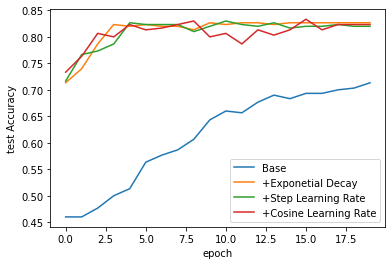

In [29]:
sns.lineplot(x='epoch', y='test Accuracy', data=unicode_results, label='Base')
sns.lineplot(x='epoch', y='test Accuracy', data=unicode_results_exp, label='+Exponetial Decay')
sns.lineplot(x='epoch', y='test Accuracy', data=unicode_results_step, label='+Step Learning Rate')
sns.lineplot(x='epoch', y='test Accuracy', data=unicode_results_cos, label='+Cosine Learning Rate')
# sns.lineplot(x='epoch', y='test Accuracy', data=unicode_results_plateau, label='+Plateau')



### Remarks

It seems like all perform quite well and I'd have to look at the results in the longer term to pick the best optimizer. Each optimizer finds the local minima MUCH faster than before. 

I could not get the plateau method to work no matter how much I tired. In reflection, I do belive it has to do with the `colllete_fn` that I am not providing to the sub_loaders. Actually I am nearly 100% that's it. 

Comments: 
- I can see the cosine annealing doing its "bouncing" as it finds the local minima near it.
- All versions appear to do quite well on this dataset. 
- I'd run this for an extended period of time to get a better idea of what's going on

# Chapter 5 Question 5
Add gradient clipping to the experiments from exercise 4. Does it help or hurt the RNN? 

In [21]:
rnn_unicode.apply(weight_reset)

eta_0 = 0.1
eta_min = 0.0001

for p in rnn_unicode.parameters(): 
    p.register_hook(lambda grad: torch.clamp(grad, -5, 5)) 

gamma_expo = (eta_min/eta_0)**(1/epoch_count)

optimizer = torch.optim.SGD(rnn_unicode.parameters(), lr=eta_0) #Set up the optimizer
scheduler = torch.optim.lr_scheduler.ExponentialLR(optimizer, gamma_expo)

unicode_results_exp_clip = train_network(rnn_unicode, loss_func, unicode_train_loader, test_loader=unicode_test_loader, epochs=epoch_count, optimizer=optimizer, lr_schedule=scheduler, score_funcs={'Accuracy': accuracy_score}, device=device)

Epoch:   0%|          | 0/20 [00:00<?, ?it/s]

Training:   0%|          | 0/1236 [00:00<?, ?it/s]

Testing:   0%|          | 0/19 [00:00<?, ?it/s]

Training:   0%|          | 0/1236 [00:00<?, ?it/s]

Testing:   0%|          | 0/19 [00:00<?, ?it/s]

Training:   0%|          | 0/1236 [00:00<?, ?it/s]

Testing:   0%|          | 0/19 [00:00<?, ?it/s]

Training:   0%|          | 0/1236 [00:00<?, ?it/s]

Testing:   0%|          | 0/19 [00:00<?, ?it/s]

Training:   0%|          | 0/1236 [00:00<?, ?it/s]

Testing:   0%|          | 0/19 [00:00<?, ?it/s]

Training:   0%|          | 0/1236 [00:00<?, ?it/s]

Testing:   0%|          | 0/19 [00:00<?, ?it/s]

Training:   0%|          | 0/1236 [00:00<?, ?it/s]

Testing:   0%|          | 0/19 [00:00<?, ?it/s]

Training:   0%|          | 0/1236 [00:00<?, ?it/s]

Testing:   0%|          | 0/19 [00:00<?, ?it/s]

Training:   0%|          | 0/1236 [00:00<?, ?it/s]

Testing:   0%|          | 0/19 [00:00<?, ?it/s]

Training:   0%|          | 0/1236 [00:00<?, ?it/s]

Testing:   0%|          | 0/19 [00:00<?, ?it/s]

Training:   0%|          | 0/1236 [00:00<?, ?it/s]

Testing:   0%|          | 0/19 [00:00<?, ?it/s]

Training:   0%|          | 0/1236 [00:00<?, ?it/s]

Testing:   0%|          | 0/19 [00:00<?, ?it/s]

Training:   0%|          | 0/1236 [00:00<?, ?it/s]

Testing:   0%|          | 0/19 [00:00<?, ?it/s]

Training:   0%|          | 0/1236 [00:00<?, ?it/s]

Testing:   0%|          | 0/19 [00:00<?, ?it/s]

Training:   0%|          | 0/1236 [00:00<?, ?it/s]

Testing:   0%|          | 0/19 [00:00<?, ?it/s]

Training:   0%|          | 0/1236 [00:00<?, ?it/s]

Testing:   0%|          | 0/19 [00:00<?, ?it/s]

Training:   0%|          | 0/1236 [00:00<?, ?it/s]

Testing:   0%|          | 0/19 [00:00<?, ?it/s]

Training:   0%|          | 0/1236 [00:00<?, ?it/s]

Testing:   0%|          | 0/19 [00:00<?, ?it/s]

Training:   0%|          | 0/1236 [00:00<?, ?it/s]

Testing:   0%|          | 0/19 [00:00<?, ?it/s]

Training:   0%|          | 0/1236 [00:00<?, ?it/s]

Testing:   0%|          | 0/19 [00:00<?, ?it/s]

In [22]:
rnn_unicode.apply(weight_reset)

for p in rnn_unicode.parameters(): 
    p.register_hook(lambda grad: torch.clamp(grad, -5, 5)) 

optimizer = torch.optim.SGD(rnn_unicode.parameters(), lr=eta_0)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, epoch_count//4, gamma=0.3)#I'm telling it to step down by a factor of $\gamma$ every epochs/4, so this will happen 4 times total. 

unicode_results_step_clip = train_network(rnn_unicode, loss_func, unicode_train_loader, test_loader=unicode_test_loader, epochs=epoch_count, optimizer=optimizer, lr_schedule=scheduler, score_funcs={'Accuracy': accuracy_score}, device=device)

Epoch:   0%|          | 0/20 [00:00<?, ?it/s]

Training:   0%|          | 0/1236 [00:00<?, ?it/s]

Testing:   0%|          | 0/19 [00:00<?, ?it/s]

Training:   0%|          | 0/1236 [00:00<?, ?it/s]

Testing:   0%|          | 0/19 [00:00<?, ?it/s]

Training:   0%|          | 0/1236 [00:00<?, ?it/s]

Testing:   0%|          | 0/19 [00:00<?, ?it/s]

Training:   0%|          | 0/1236 [00:00<?, ?it/s]

Testing:   0%|          | 0/19 [00:00<?, ?it/s]

Training:   0%|          | 0/1236 [00:00<?, ?it/s]

Testing:   0%|          | 0/19 [00:00<?, ?it/s]

Training:   0%|          | 0/1236 [00:00<?, ?it/s]

Testing:   0%|          | 0/19 [00:00<?, ?it/s]

Training:   0%|          | 0/1236 [00:00<?, ?it/s]

Testing:   0%|          | 0/19 [00:00<?, ?it/s]

Training:   0%|          | 0/1236 [00:00<?, ?it/s]

Testing:   0%|          | 0/19 [00:00<?, ?it/s]

Training:   0%|          | 0/1236 [00:00<?, ?it/s]

Testing:   0%|          | 0/19 [00:00<?, ?it/s]

Training:   0%|          | 0/1236 [00:00<?, ?it/s]

Testing:   0%|          | 0/19 [00:00<?, ?it/s]

Training:   0%|          | 0/1236 [00:00<?, ?it/s]

Testing:   0%|          | 0/19 [00:00<?, ?it/s]

Training:   0%|          | 0/1236 [00:00<?, ?it/s]

Testing:   0%|          | 0/19 [00:00<?, ?it/s]

Training:   0%|          | 0/1236 [00:00<?, ?it/s]

Testing:   0%|          | 0/19 [00:00<?, ?it/s]

Training:   0%|          | 0/1236 [00:00<?, ?it/s]

Testing:   0%|          | 0/19 [00:00<?, ?it/s]

Training:   0%|          | 0/1236 [00:00<?, ?it/s]

Testing:   0%|          | 0/19 [00:00<?, ?it/s]

Training:   0%|          | 0/1236 [00:00<?, ?it/s]

Testing:   0%|          | 0/19 [00:00<?, ?it/s]

Training:   0%|          | 0/1236 [00:00<?, ?it/s]

Testing:   0%|          | 0/19 [00:00<?, ?it/s]

Training:   0%|          | 0/1236 [00:00<?, ?it/s]

Testing:   0%|          | 0/19 [00:00<?, ?it/s]

Training:   0%|          | 0/1236 [00:00<?, ?it/s]

Testing:   0%|          | 0/19 [00:00<?, ?it/s]

Training:   0%|          | 0/1236 [00:00<?, ?it/s]

Testing:   0%|          | 0/19 [00:00<?, ?it/s]

In [23]:
rnn_unicode.apply(weight_reset)

for p in rnn_unicode.parameters(): 
    p.register_hook(lambda grad: torch.clamp(grad, -5, 5)) 

optimizer = torch.optim.SGD(rnn_unicode.parameters(), lr=eta_0)
scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, epoch_count//3, eta_min=0.0001)

unicode_results_cos_clip = train_network(rnn_unicode, loss_func, unicode_train_loader, test_loader=unicode_test_loader, epochs=epoch_count, optimizer=optimizer, lr_schedule=scheduler, score_funcs={'Accuracy': accuracy_score}, device=device)

Epoch:   0%|          | 0/20 [00:00<?, ?it/s]

Training:   0%|          | 0/1236 [00:00<?, ?it/s]

Testing:   0%|          | 0/19 [00:00<?, ?it/s]

Training:   0%|          | 0/1236 [00:00<?, ?it/s]

Testing:   0%|          | 0/19 [00:00<?, ?it/s]

Training:   0%|          | 0/1236 [00:00<?, ?it/s]

Testing:   0%|          | 0/19 [00:00<?, ?it/s]

Training:   0%|          | 0/1236 [00:00<?, ?it/s]

Testing:   0%|          | 0/19 [00:00<?, ?it/s]

Training:   0%|          | 0/1236 [00:00<?, ?it/s]

Testing:   0%|          | 0/19 [00:00<?, ?it/s]

Training:   0%|          | 0/1236 [00:00<?, ?it/s]

Testing:   0%|          | 0/19 [00:00<?, ?it/s]

Training:   0%|          | 0/1236 [00:00<?, ?it/s]

Testing:   0%|          | 0/19 [00:00<?, ?it/s]

Training:   0%|          | 0/1236 [00:00<?, ?it/s]

Testing:   0%|          | 0/19 [00:00<?, ?it/s]

Training:   0%|          | 0/1236 [00:00<?, ?it/s]

Testing:   0%|          | 0/19 [00:00<?, ?it/s]

Training:   0%|          | 0/1236 [00:00<?, ?it/s]

Testing:   0%|          | 0/19 [00:00<?, ?it/s]

Training:   0%|          | 0/1236 [00:00<?, ?it/s]

Testing:   0%|          | 0/19 [00:00<?, ?it/s]

Training:   0%|          | 0/1236 [00:00<?, ?it/s]

Testing:   0%|          | 0/19 [00:00<?, ?it/s]

Training:   0%|          | 0/1236 [00:00<?, ?it/s]

Testing:   0%|          | 0/19 [00:00<?, ?it/s]

Training:   0%|          | 0/1236 [00:00<?, ?it/s]

Testing:   0%|          | 0/19 [00:00<?, ?it/s]

Training:   0%|          | 0/1236 [00:00<?, ?it/s]

Testing:   0%|          | 0/19 [00:00<?, ?it/s]

Training:   0%|          | 0/1236 [00:00<?, ?it/s]

Testing:   0%|          | 0/19 [00:00<?, ?it/s]

Training:   0%|          | 0/1236 [00:00<?, ?it/s]

Testing:   0%|          | 0/19 [00:00<?, ?it/s]

Training:   0%|          | 0/1236 [00:00<?, ?it/s]

Testing:   0%|          | 0/19 [00:00<?, ?it/s]

Training:   0%|          | 0/1236 [00:00<?, ?it/s]

Testing:   0%|          | 0/19 [00:00<?, ?it/s]

Training:   0%|          | 0/1236 [00:00<?, ?it/s]

Testing:   0%|          | 0/19 [00:00<?, ?it/s]

<AxesSubplot:xlabel='epoch', ylabel='test Accuracy'>

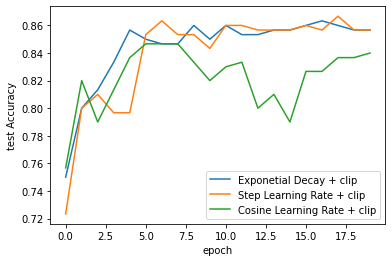

In [24]:
sns.lineplot(x='epoch', y='test Accuracy', data=unicode_results_exp_clip, label='Exponetial Decay + clip')
sns.lineplot(x='epoch', y='test Accuracy', data=unicode_results_step_clip, label='Step Learning Rate + clip')
sns.lineplot(x='epoch', y='test Accuracy', data=unicode_results_cos_clip, label='Cosine Learning Rate + clip')

### Remarks

For both step and exponetial learning rates it looks like there is maybe a slight increase with gradiant clipping. The cosine anealing on the otherhand looks to actually only be harmed by the clamping. Maybe there is an interaction between the cosine's bounding and the clamping that make it perform much worse. It could also be that more epochs would yeild a better result for cosine anealling. 